In [1]:
# Import all necessary packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from tensorflow.keras.models import Model,load_model

2024-02-21 10:26:35.417428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 402
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.95
t_final = 0.01
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

In [3]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 30, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 30, endpoint=True)
T_initial = np.linspace(300, 600, 50, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 50, endpoint=True) - C_As

In [4]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 190
shape of x_deviation is (190, 2)


In [5]:
# Open-loop simulations of the first-principles model of CSTR

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """
    
    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time
    
    C_A = C_A_initial + C_As
    T = T_initial + T_s
    
    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)
        
        C_A += dCAdt * t_step
        T += dTdt * t_step

        if (i+1)% 10 == 0:
            C_A_list.append(C_A - C_As)  # in deviation form
            T_list.append(T - T_s)  # in deviation form 
    
        
    return C_A_list, T_list

In [6]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s
    
    for u2 in u2_list:
        Q = u2 + Q_s
        
        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)
            
            C_A_list, T_list = \
                CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [7]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

RNN_input = np.concatenate((CA_input, T_input, CA0_input, Q_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""
RNN_input = RNN_input.repeat(10, axis=1) # 10 time steps in this example
print("RNN_input shape is {}".format(RNN_input.shape))

# checking the input is duplicated 10 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

RNN_input shape is (171000, 10, 4)
[ 1.35612245e+00 -7.13877551e+01 -3.50000000e+00 -5.00000000e+05]
[ 1.35612245e+00 -7.13877551e+01 -3.50000000e+00 -5.00000000e+05]


In [8]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, 10, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, 10, 1)

RNN_output = np.concatenate((CA_output, T_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

# checking output
print('RNN_output shape is',RNN_output.shape)

RNN_output shape is (171000, 10, 2)
RNN_output shape is (171000, 10, 2)


In [9]:
# Normalization

scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

print(scaler_X.mean_)
print(scaler_X.var_)
print(scaler_y.mean_)
print(scaler_y.var_)

RNN_input = scaler_X.transform(RNN_input.reshape(-1, 4)).reshape(-1,10,4)
RNN_output = scaler_y.transform(RNN_output.reshape(-1, 2)).reshape(-1,10,2)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

# checking X_train
print(X_train[0, 0])
print(X_train[0, 1])

[ 7.25026853e-03 -3.35123523e-01 -5.10593517e-17  0.00000000e+00]
[7.01467140e-01 1.41521192e+03 4.36494253e+00 8.90804598e+10]
[ 0.01304949 -0.62300591]
[6.86987919e-01 1.48200017e+03]
[-0.72869851  1.20347524 -0.98204119 -0.51990416]
[-0.72869851  1.20347524 -0.98204119 -0.51990416]


In [10]:
np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)
np.save('X_mean.npy',scaler_X.mean_)
np.save('X_std.npy',np.sqrt(scaler_X.var_))
np.save('y_mean.npy',scaler_y.mean_)
np.save('y_std.npy',np.sqrt(scaler_y.var_))

2024-02-21 10:28:25.422320: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-21 10:28:25.423406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-21 10:28:25.451859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-21 10:28:25.451941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2024-02-21 10:28:25.451957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-21 10:28:25.453190: I tensorflow/stream_executor/platform/default/

Epoch 1/100


2024-02-21 10:28:28.464707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-21 10:28:29.070909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-02-21 10:28:29.238823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-02-21 10:28:51.294480: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


421/421 - 27s - loss: 0.0840 - val_loss: 0.0031
Epoch 2/100
421/421 - 1s - loss: 0.0018 - val_loss: 8.7862e-04
Epoch 3/100
421/421 - 1s - loss: 4.6085e-04 - val_loss: 1.7768e-04
Epoch 4/100
421/421 - 1s - loss: 8.0227e-05 - val_loss: 3.4171e-05
Epoch 5/100
421/421 - 1s - loss: 2.3749e-05 - val_loss: 1.7404e-05
Epoch 6/100
421/421 - 1s - loss: 1.5054e-05 - val_loss: 1.1524e-05
Epoch 7/100
421/421 - 1s - loss: 1.3127e-05 - val_loss: 1.0504e-05
Epoch 8/100
421/421 - 1s - loss: 1.3166e-05 - val_loss: 7.6837e-06
Epoch 9/100
421/421 - 1s - loss: 9.4243e-06 - val_loss: 6.6791e-06
Epoch 10/100
421/421 - 1s - loss: 1.2481e-05 - val_loss: 6.4639e-06
Epoch 11/100
421/421 - 1s - loss: 9.4851e-06 - val_loss: 6.6650e-06
Epoch 12/100
421/421 - 1s - loss: 1.2279e-05 - val_loss: 2.5351e-05
Epoch 13/100
421/421 - 1s - loss: 9.6027e-06 - val_loss: 5.1697e-06
Epoch 14/100
421/421 - 1s - loss: 1.1595e-05 - val_loss: 8.2628e-06
Epoch 15/100
421/421 - 1s - loss: 1.0947e-05 - val_loss: 1.4353e-05
Epoch 16/100

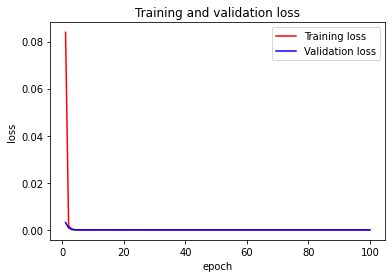

In [11]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')


model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(Dense(2, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.1, verbose=2)


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [12]:
# Evaluation on Test Data Set
print(model.evaluate(X_test,y_test))

1604/1604 [==============================] - 2s 1ms/step - loss: 1.4797e-06
1.479692400607746e-06


In [13]:
model.save('model.h5')

/tmp/ipykernel_2210252/1511572212.py:20: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


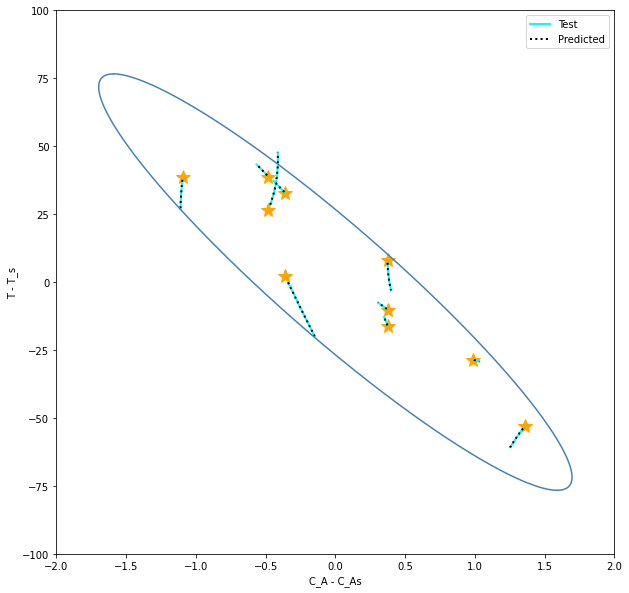

In [25]:

model = load_model('model.h5')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
Input_mean = np.load('X_mean.npy')
Input_std = np.load('X_std.npy')
Output_mean = np.load('y_mean.npy')
Output_std = np.load('y_std.npy')

"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

# plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
y_predict = y_predict * Output_std + Output_mean
y_test = y_test * Output_std + Output_mean
X_plot = X_test * Input_std + Input_mean


for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15,color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15,color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':')

    
# plot stability region        
plt.plot(x_lower, y_plot, color='steelblue')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()       
        